In [69]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor,get_graph_node_names
import os 
import numpy as np
import import_ipynb
from RetinaFPN import RetinaFPN as RetinaFPN
from Retina_Classification import Classification as Classification
from Retina_Regression import Regression as Regression
from Create_Anchors import Anchors as Anchors

### Focal Loss 
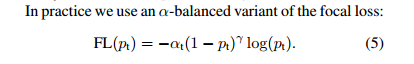
where 
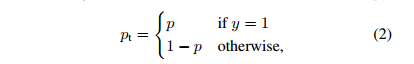
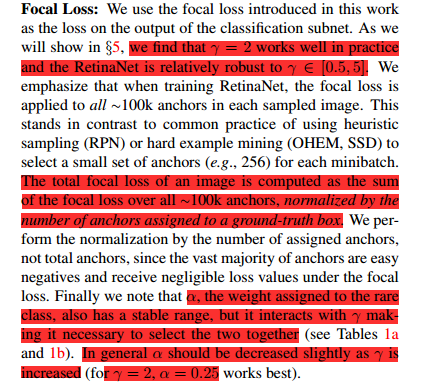

### IoU
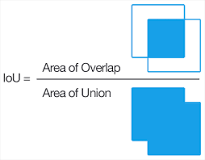

### Bounding Box Regression
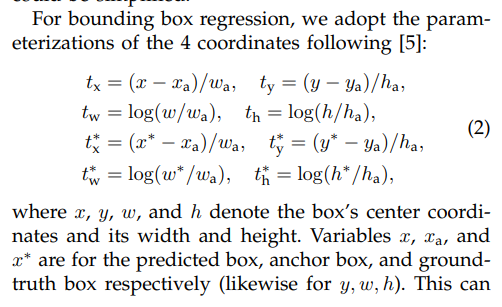


In [320]:
class Focal_Loss(nn.Module):
    def __init__(self, anchors, alpha=None, gamma=None):
        super(Focal_Loss).__init__()
        super().__init__()
        if alpha is None: self.alpha = 0.25
        else: self.alpha = alpha
        if gamma is None: self.gamma = 2.0
        else: self.gamma = gamma
        self.anchors = torch.squeeze(anchors, dim=0)
        self.anchor_widths = self.anchors[:,2] - self.anchors[:,0]
        self.anchor_heights = self.anchors[:,3] - self.anchors[:,1]
        self.anchor_center_xs = self.anchors[:,0] + 0.5*self.anchor_widths
        self.anchor_center_ys = self.anchors[:,1] + 0.5*self.anchor_heights
 
    def _classification_loss(self, classification, alpha, gamma):
        if torch.cuda.is_available():
            alpha_factor = 1. - torch.ones(classification.shape).cuda()*alpha
        else:
            alpha_factor = 1. - torch.ones(classification.shape)*alpha   

        focal_weight = alpha_factor*(torch.pow(classification, self.gamma))
        focal_loss = focal_weight*(-(torch.log(1-classification)))
        return focal_loss.sum()

    def _IoU(self, anchor_bdx, annotation_bdx):            
    # bounding box overlap area 
        w =  torch.min(torch.unsqueeze(anchor_bdx[:,2], dim=1), annotation_bdx[:,2])
        -torch.max(torch.unsqueeze(anchor_bdx[:,0], dim=1), annotation_bdx[:,0])
        h =  torch.min(torch.unsqueeze(anchor_bdx[:,3],dim=1), annotation_bdx[:,3])
        -torch.max(torch.unsqueeze(anchor_bdx[:,1], dim=1), annotation_bdx[:,1])
        w = torch.clamp(w, min=0)
        h = torch.clamp(h, min=0)
        intersection = w*h

        area_anchor_bdx = (anchor_bdx[:,2] - anchor_bdx[:,0])*(anchor_bdx[:,3] - anchor_bdx[:,1])
        area_annotation_bdx = (annotation_bdx[:,2] - annotation_bdx[:,0])*(annotation_bdx[:,3] - annotation_bdx[:,1])
        union_area = torch.unsqueeze(area_anchor_bdx, dim=1)  + area_annotation_bdx - intersection 

        IoU = torch.clamp(intersection/union_area, min=0, max=1)
        return IoU

    def _cal_distance(self, y_true, y_pred):
        abs_diff = torch.abs(y_true - y_pred)
        squared_diff = abs_diff**2
        return abs_diff, squared_diff
    
    
    def _regression_loss(self, classification, regression, annotation):
        IoU = self._IoU(self.anchors[:,:], annotation[:, :4]) #num_anchors x num_annotations
        
        # Anchor that have highest IOU is considered to be an object 
        IoU_max, IoU_max_ind = torch.max(IoU, dim=1) # num_anchors x 1
    
        targets = torch.ones(classification.shape) * -1
        # Now check IoU, if it's less than 0.4 -> background
        targets[torch.lt(IoU_max, 0.4),:] = 0
        if torch.cuda.is_available():
            targets = targets.cuda()
        
        positive_ind = torch.ge(IoU_max, 0.5) 
        num_positive_anchors = positive_ind.sum()
        
        # assign the annotation 
        assigned_annotations = annotation[IoU_max_ind, :]
        
        # assign the corresponding class for the positive anchors to be 1 
        targets[positive_ind,:] = 0
        targets[positive_ind, assigned_annotations[positive_ind, 4].long()] = 1
        
        if num_positive_anchors >= 0:
            assigned_annotations = assigned_annotations[positive_ind,:]
            anchor_widths_pos = self.anchor_widths[positive_ind]
            anchor_heights_pos = self.anchor_heights[positive_ind]
            anchor_center_xs_pos = self.anchor_center_xs[positive_ind]
            anchor_center_ys_pos = self.anchor_center_ys[positive_ind]
            
            # ground-truth 
            gt_widths = assigned_annotations[:,2] - assigned_annotations[:,0]
            gt_heights = assigned_annotations[:,3] - assigned_annotations[:,1]
            gt_center_xs = assigned_annotations[:,0] + 0.5*gt_widths
            gt_center_ys = assigned_annotations[:,1] + 0.5*gt_heights
            
            # clip gt_widths to be 1 to avoid value blowing up
            gt_widths = torch.clamp(gt_widths, min=1)
            gt_heights = torch.clamp(gt_heights, min=1)
            
            # calculate the delta from real coordinate/ the loss t*
            delta_x = (gt_center_xs - anchor_center_xs_pos)/anchor_widths_pos
            delta_y = (gt_center_ys - anchor_center_ys_pos)/anchor_heights_pos
            delta_w = torch.log(gt_widths/anchor_widths_pos)
            delta_h = torch.log(gt_heights/anchor_heights_pos)
            
            targets = torch.stack((delta_x, delta_y, delta_w, delta_h))
            targets = targets.t()
            
            abs_diff, squared_diff = self._cal_distance(targets, regression[positive_ind,:4])
            regression_loss = torch.where(torch.le(abs_diff, 1/9), 0.5*9*squared_diff, abs_diff-0.5/9)
            #print(regression_loss)
            
            return (regression_loss.mean())
        
    def forward(self, classifications, regressions, annotations):
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        for img in range(batch_size):
            regression = regressions[img, :, :] #total_num_anchors*4 (4 is for bounding box)
            classification = classifications[img, :, :] #total_num_anchors * num_class
            annotation = annotations[img, :, :]
            classification = torch.clamp(classification, 1e-6, 1-1e-6)
            classification_losses.append(self._classification_loss(classification, self.alpha, self.gamma))
            regression_losses.append(self._regression_loss(regression, classification, annotation))
        return torch.stack(classification_losses).mean(dim=0, keepdim=True), torch.stack(regression_losses).mean(dim=0, keepdim=True)






In [232]:
net = RetinaFPN()
x = net(torch.randn(1,3,600,600))
features_size = np.array([xx.shape for xx in x])
print(features_size.shape)
a = Anchors(features_size)
print(a())
print(a().shape)

(5, 4)
tensor([[[  -7.3137,  -18.6274,   15.3137,   26.6274],
         [ -12.0000,  -12.0000,   20.0000,   20.0000],
         [ -18.6274,   -7.3137,   26.6274,   15.3137],
         ...,
         [1627.9299, 1399.8599, 2084.0701, 2312.1401],
         [1533.4602, 1533.4602, 2178.5398, 2178.5398],
         [1399.8599, 1627.9299, 2312.1401, 2084.0701]]])
torch.Size([1, 66852, 4])


In [252]:
regress_net = Regression(256, 5)
regress_net = Regression(256, 3)
x_regress = torch.cat([regress_net(x[i]) for i in range(len(x))], dim=1)

In [253]:
classify_net = Classification(256, 5)
x_class = torch.cat([classify_net(x[i]) for i in range(len(x))], dim=1)

In [254]:
print(x_class.shape)
print(xregress.shape)

torch.Size([1, 66852, 5])
torch.Size([1, 66852, 4])


In [255]:
fake_annotation = np.array([[30, 20, 50, 70, 1],[45, 80, 30, 80, 0]])
print(fake_annotation.shape)
fake_annotation =  np.expand_dims(fake_annotation,0)
print(fake_annotation.shape)
fake_annotation = torch.from_numpy(fake_annotation)
type(fake_annotation)

(2, 5)
(1, 2, 5)


torch.Tensor

In [268]:
print(a().shape)

torch.Size([1, 66852, 4])


In [321]:
L = Focal_Loss(a())
class_loss, regress_loss = L(x_class, x_regress, fake_annotation)

In [322]:
print(class_loss)
print(regress_loss)

tensor([43503.4414], grad_fn=<MeanBackward1>)
tensor([2.6234], grad_fn=<MeanBackward1>)
